# Autoencoders

We import the usual stuff including the 3 miniai modules.

In [1]:
import pickle,gzip,math,os,time,shutil,torch,logging
import matplotlib as mpl,numpy as np,matplotlib.pyplot as plt, fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

from fastcore.test import test_close

In [2]:
if torch.cuda.is_available():
    def_device = torch.device("cuda")
    print("✅ CUDA device is available.")
elif torch.backends.mps.is_available():
    def_device = torch.device("mps")
    print("❌ CUDA device is NOT available.")
    print("✅ MPS device is available.")
else:
    def_device = torch.device("cpu")
    print("🖥️ Using CPU (neither CUDA nor MPS available).")

print(f"Selected device: {def_device}")

❌ CUDA device is NOT available.
✅ MPS device is available.
Selected device: mps


In [3]:
logging.disable(logging.WARNING)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

## Data
We have not yet built any models with the `fashion_mnist` dataset so let's load it into `dsd` and then build a model.
We can take advantage of 05_datasets.ipynb and the huggingface datasets to load it.

In [4]:
from datasets.utils.info_utils import VerificationMode

x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name, verification_mode=VerificationMode.NO_CHECKS) # ignore_verifications=True)

In [5]:
type(dsd['train'][0][x])

PIL.PngImagePlugin.PngImageFile

The images are of type `PIL.PngImagePlugin.PngImageFile`.
Given a batch `b` we want to convert each image `b[x]` into a `Tensor` in an `@inplace` transform.

In [6]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

We call data set dictionary `with_transform` to do the transform.

In [7]:
tds = dsd.with_transform(transformi)
tds.items(), "\n", type(tds['train'][0][x])

(dict_items([('train', Dataset({
     features: ['image', 'label'],
     num_rows: 60000
 })), ('test', Dataset({
     features: ['image', 'label'],
     num_rows: 10000
 }))]),
 '\n',
 torch.Tensor)

Below examples of images from the train and test datasets.

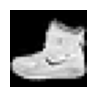

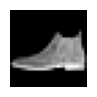

In [8]:
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(1,1));
show_image(tds['test'][0]['image'], figsize=(1,1));

Lets define `cf` as a collation function to collating the dictionary for that dataset 
(`collate_dict` from 05_datasets notebook).

In [9]:
cf = collate_dict(ds)

Let's have our `collate_` function use `to_device` (from earlier notebook) 

In [10]:
def collate_(b): return to_device(cf(b))

Lets define a `data_loaders()` to go through each item (`train` and `test`) in the dataset dictionary `dsd`,
create a `DataLoader` for each, and return a dictionary of data loaders.

In [11]:
def data_loaders(dsd, bs, **kwargs): 
    return {k:DataLoader(v, bs, **kwargs) for k,v in dsd.items()}

dls = data_loaders(tds, bs=256, collate_fn=collate_)
dls

{'train': <torch.utils.data.dataloader.DataLoader at 0x12df70bf0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x12be99580>}

`dls` has a dataloader for `train` (`dt`) and a dataloader for `test` (`dv` for validation).
We can grab the `xb` and `yb` batch by calling `next` on the `dt` iterator.

In [12]:
dt = dls['train']
dv = dls['test']

xb,yb = next(iter(dt))

From `ds` we get the `names` of the `features` so we can then create `lbl_getter`, an `itemgetter` for the labels (y's).
`lbl_getter(labels)` returns the titles of items in the dataset `ds`.

In [13]:
labels = ds.features[y].names
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Lets get the titles of the first 16 images

In [14]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)
titles[:16]

('Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top',
 'Pullover',
 'Sneaker',
 'Pullover',
 'Sandal',
 'Sandal',
 'T - shirt / top',
 'Ankle boot',
 'Sandal',
 'Sandal',
 'Sneaker',
 'Ankle boot')

We can then call `show_images` with that minibatch and with those titles and display (below) a fashion mnist minibatch.
<br>
Matplotlib's `mpl.rcParams` is a dict-like key-value store for config parameters, including validation.

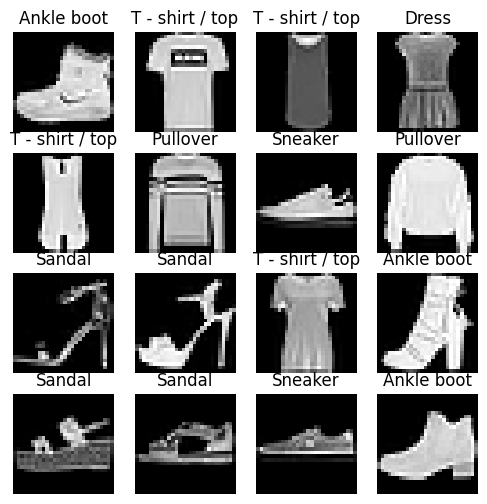

In [15]:
mpl.rcParams['figure.dpi'] = 100
show_images(xb[:16], imsize=1.5, titles=titles)

## Warmup - classify

Lets create a classifier using the code from previous notebooks.

In [16]:
from torch import optim

#bs = 256
#lr = 0.4

Let's create a classifier with the same code (copy and paste) as `simple_cnn` from the `07_convolutions` notebook.
`cnn` is our sequential model and we move it to  the default device.

In [17]:
cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False),
    nn.Flatten()).to(def_device)

We pass to the optimizer `cnn.parameters()`, which Returns an iterator over module parameters.

In [18]:
opt = optim.SGD(cnn.parameters(), lr=0.4)

and we call miniai `fit()`

In [19]:
%%time
loss,acc = fit(epochs=5, model=cnn, loss_func=F.cross_entropy, opt=opt, train_dl=dt, valid_dl=dv)

0 0.9394506675720214 0.6782
1 0.5829048480033875 0.7923
2 0.4688592580318451 0.8323
3 0.4365898666381836 0.8424
4 0.4241420591831207 0.8489
CPU times: user 10.9 s, sys: 442 ms, total: 11.4 s
Wall time: 12.4 s


Why is it fitting so slowly?
From the original data set dictionary `dsd`,  (before it gets transformed into `tds`), lets grab one item from the training part.

In [20]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In this HuggingFace dataset each `image` is a separate PNG (Portable Network Graphics) image.
In contrast, for the MNIST dataset we had all the data loaded into memory into a single big tensor.
As it is not all pre-converted, the data loader is spending much time decoding the PNGs.
With htop, while training, we see that a single CPU is 100% used, but the GPU only has 1% utilization. 
To make it faster we want to use multiple CPUs to decode PNGs.
We add an extra argument to the data loaders, `num_workers`, e.g., use eight CPUs.
But then we get a "quirky" error, trying to use multiple processes.
Generally in Python and Pytorch using multiple processes gets complicated, 
as we can't have a dataloader put things onto the GPU in separate processes.
The cause for the error is that we used a collate function that put things on the device that is incompatible to using multiple workers. 
To address this problem we have to rewrite our fit function.

## Autoencoder
An autoencoder is a type of neural network that **learns to compress and reconstruct data.** 
It's typically used for:
-    Dimensionality reduction: Reducing the number of features in a dataset while preserving important information.
-    Anomaly detection: Identifying unusual patterns or outliers in data.
-    Data denoising: Removing noise or errors from data.
-    Feature learning: Automatically learning useful features from raw data.

An autoencoder consists of two main parts:
-    Encoder: Maps the input data to a lower-dimensional representation (bottleneck layer).
-    Decoder: Maps the lower-dimensional representation back to the original input data.

The autoencoder is trained to minimize the difference between the input data and its reconstructed version, which forces the network to learn a compact and meaningful representation of the data.

We're building an autoencoder that compresses a 28x28 image through stride-2 convolutions. 
First, we reduce it to 14x14x2, then to 7x7x4, achieving a 4x reduction in spatial dimensions while increasing channels. 
This process compresses the image.

Now we could have a convolution layer (or group of layers), which does a convolution and also increases the size.
<br>
*Transposed convolution*, also known as *deconvolution* or *fractionally strided convolution*, 
upsamples data by adding zero-padding between input values and applying regular convolution. 
It learns a filter to produce a larger output, often used in autoencoders and GANs. 
**NB:** a transposed convolution is not the exact reverse of a regular convolution, it doesn't undo a convolution operation. 

**Nearest neighbor upsampling**
doubles the grid size by copying pixels, followed by a stride-1 convolution. 
This is a simpler way, essentially "filling in" the extra spaces with the value of the nearest pixel. 
For example, given 3x3 pixels, we make it into a 6x6 by copying each pixel into 4 pixels.
It is not a convolution, it is just copying, but then we can apply a stride-1 convolution and that would double the grid size.
<br>
Our autoencoder needs a deconvolutional layer `deconv()` that has two layers:
[UpsamplingNearest2d](https://pytorch.org/docs/stable/generated/torch.nn.UpsamplingNearest2d.html) with `(scale_factor=2)` followed by a [Conv2d](https://pytorch.org/docs/stable/generated/torch.ao.nn.quantized.functional.conv2d.html?highlight=conv2d) with a `stride=1`.
For padding `ks//2` (a truncating division) always works for any odd sized kernel.
As before we have an optional activation function (`Relu`).
Then create a `Sequential` using `*layers` so it's going to pass-in each layer as a separate argument, which is what Sequential expects.

In [21]:
def deconv(ni, nf, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

We pull out `eval()` into a separate function to simplify `fit()` below.

In [22]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for xb,_ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred,xb).item()*n
    print(epoch, f'{tot_loss/count:.3f}')

Below is a new `fit` function, copied over from our previous one (04_minibatch notebook), going through each epoch.

In [23]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,_ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch)

### A simple autoencoder
Below code assigns to `ae` a simple autoencoder neural network using PyTorch's `nn.Sequential`. 
The architecture is designed to compress (encode) and then reconstruct (decode) 28×28 grayscale images.
First it uses [ZeroPad2d(2)](https://pytorch.org/docs/stable/generated/torch.nn.ZeroPad2d.html?highlight=zeropad2d#torch.nn.ZeroPad2d)
to add padding of two on each side, and get a 32x32.
Then a `conv(1,2)` with two channel output, that gives a 16x16x2,
and then a `conv(2,4)` to get an 8x8x4. 
(Commented out again to get a 4x4x8, followed by `deconv` for a 8x8). 
So this is doing an 8X compression.
Then we can call deconv to do exactly the same thing in reverse.
The final one with no activation (act=False) and
then `ZeroPad2d(-2)` to truncate off those two pixels off the edge.
Finally, [nn.Sigmoid()](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html?highlight=nn+sigmoid#torch.nn.Sigmoid) 
forces everything to go between 0 and 1 which we need.

In [24]:
ae = nn.Sequential(
    nn.ZeroPad2d(2),           # Pad 28x28 to 32x32
    conv(1, 2),                # Downsample to 16x16
    conv(2, 4),                # Downsample to 8x8
#     conv(4,8),        #4x4
#     deconv(8,4),      #8x8
    deconv(4, 2),              # Upsample to 16x16
    deconv(2, 1, act=False),   # Upsample to 32x32
    nn.ZeroPad2d(-2),          # Crop back to 28x28
    nn.Sigmoid()               # Normalize output between 0 and 1
).to(def_device)

Now use `mse_loss` to compare those pixels `ae` to our input pixels `dv`.
<br>
**NB:** the loss function is being applied to the output of the model and itself. 
We don't have YBs (labels) here we have xBs.
<br>
We are trying to recreate our original fit function, so we can now see what is the MSE loss.
It's not going to be particularly human readable, but it's a number, we can see if it goes down.

In [25]:
eval(model=ae, loss_func=F.mse_loss, valid_dl=dv)

0 0.182


We can train the autoencoder using SGD with MSE loss, but it's slow. 
Upon training, the `ae` autoencoder **fails** to accurately recreate the original image.

In [26]:
opt = optim.SGD(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.154
1 0.139
2 0.130
3 0.126
4 0.125


In [27]:
opt = optim.SGD(ae.parameters(), lr=0.001)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.125
1 0.125
2 0.125
3 0.125
4 0.125


**NB** The autoencoder's training stalled with a high error rate (0.124), resulting in poor image reconstruction. 
Previously, it showed promise with lower error rates (0.034). To improve, it may require a better optimizer (e.g., Adam), architecture adjustments, or exploring variational autoencoders, as current results are disappointing.

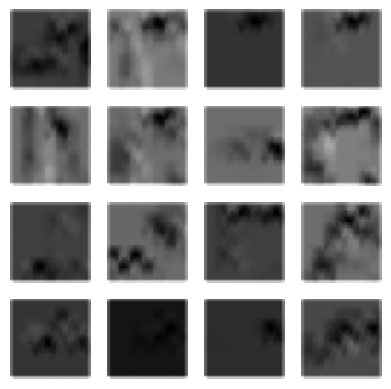

In [28]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.2)

Compare with the originals below:

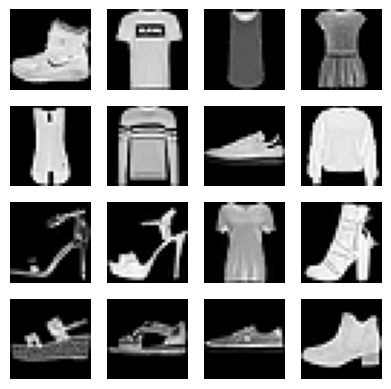

In [29]:
show_images(xb[:16].data.cpu(), imsize=1.2)

**NB:** This way "will drive us crazy."
We need to be able to rapidly try all kinds of different things.
JH often sees in projects/kaggle code that is all manual, then iteration speed is too slow.
We need to be able to rapidly try things so we're not going to keep doing stuff manually anymore. 
**Let's build up a framework to rapidly try things and understand when things are and are not working.**
We are going to start creating a learner from scratch.